In [26]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
from lenstronomy.SimulationAPI.ObservationConfig import Roman as RomanLenstronomy
from lenstronomy.SimulationAPI.sim_api import SimAPI

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.lenses.test import SampleStrongLens, SampleStrongLens2
from mejiro.exposure import Exposure
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [99]:
lens = SampleStrongLens()
# realization = lens.generate_cdm_subhalos()
# lens.add_subhalos(realization)
roman = Roman()
band = 'F129'
scene_size = 5  # arcsec
oversample = 1
exposure_time = 146
instrument_params = {
    'detector': 1,
    'detector_position': (2048, 2048)
}

synth = SyntheticImage(lens, roman, band, arcsec=scene_size, oversample=oversample, pieces=False, verbose=True,
                       instrument_params=instrument_params)

Computing on pixel grid of size 47x47 (5.17"x5.17") with pixel scale 0.11 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 1)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F129 band


In [100]:
strong_lens = synth.strong_lens
band = synth.band

roman_obs_config = RomanLenstronomy.Roman(band=band,
                                          psf_type='PIXEL',
                                          survey_mode='wide_area')
roman_obs_config.obs['num_exposures'] = 1  # set number of exposures to 1 cf. 96
roman_obs_config.obs['exposure_time'] = exposure_time

psf = roman_obs_config.obs['kernel_point_source']

sim_api = SimAPI(numpix=synth.native_num_pix,
                 kwargs_single_band=roman_obs_config.kwargs_single_band(),
                 kwargs_model=strong_lens.kwargs_model)

imsim = sim_api.image_model_class({
    'supersampling_factor': 3,
    'compute_mode': 'regular'
})

kwargs_lens = strong_lens.kwargs_lens
kwargs_lens_light = [strong_lens.kwargs_lens_light_amp_dict[band]]
kwargs_source = [strong_lens.kwargs_source_amp_dict[band]]

total_image = imsim.image(kwargs_lens, kwargs_source, kwargs_lens_light, None)

noise = sim_api.noise_for_model(model=total_image)
total_image += noise

# if any unphysical negative pixels exist, set them to minimum value
total_image = util.replace_negatives(total_image, util.smallest_non_negative_element(total_image))

In [101]:
# pprint(kwargs_lens)
# print('\n')
# pprint(kwargs_source)
# print('\n')
# pprint(kwargs_lens_light)

In [105]:
pprint(strong_lens.kwargs_model)

{'cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897),
 'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
 'lens_redshift_list': [0.2902115249535011,
                        0.2902115249535011,
                        0.2902115249535011],
 'source_light_model_list': ['SERSIC_ELLIPSE'],
 'source_redshift_list': [0.5876899931818929],
 'z_source': 0.5876899931818929,
 'z_source_convention': 5}


In [111]:
strong_lens = synth.strong_lens
band = synth.band

roman_obs_config = RomanLenstronomy.Roman(band=band,
                                          psf_type='PIXEL',
                                          survey_mode='wide_area')
roman_obs_config.obs['num_exposures'] = 1  # set number of exposures to 1 cf. 96
roman_obs_config.obs['exposure_time'] = exposure_time

psf = roman_obs_config.obs['kernel_point_source']

kwargs_model = {
    'lens_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_model_list': ['EPL', 'SHEAR'],
    'lens_redshift_list': [0.5] * 2,
    'source_light_model_list': ['SERSIC'],
    'source_redshift_list': [1.],
    'z_source': 1.
}

sim_api = SimAPI(numpix=synth.native_num_pix,
                 kwargs_single_band=roman_obs_config.kwargs_single_band(),
                 kwargs_model=kwargs_model)

imsim = sim_api.image_model_class({
    'supersampling_factor': 3,
    'compute_mode': 'regular'
})

# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['EPL', 'SHEAR']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

kwargs_spep = {'theta_E': 1.1, 'e1': 0.1, 'e2': 0.1, 'gamma': 2., 'center_x': 0.1, 'center_y': 0}
kwargs_shear = {'gamma1': -0.01, 'gamma2': .03}
kwargs_lens = [kwargs_spep, kwargs_shear]

import lenstronomy.Util.param_util as param_util

e1, e2 = param_util.phi_q2_ellipticity(phi=0.5, q=0.7)
kwargs_light_lens = [
    {'amp': 1000, 'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': e1, 'e2': e2, 'center_x': 0.1, 'center_y': 0}]
theta_ra, theta_dec = 1., .5
beta_ra, beta_dec = lensModel.ray_shooting(theta_ra, theta_dec, kwargs_lens)
kwargs_source = [{'amp': 100, 'R_sersic': 0.1, 'n_sersic': 1.5, 'center_x': beta_ra, 'center_y': beta_dec}]

total_image = imsim.image(kwargs_lens, kwargs_source, kwargs_lens_light, None)

noise = sim_api.noise_for_model(model=total_image)
total_image += noise

# if any unphysical negative pixels exist, set them to minimum value
total_image = util.replace_negatives(total_image, util.smallest_non_negative_element(total_image))

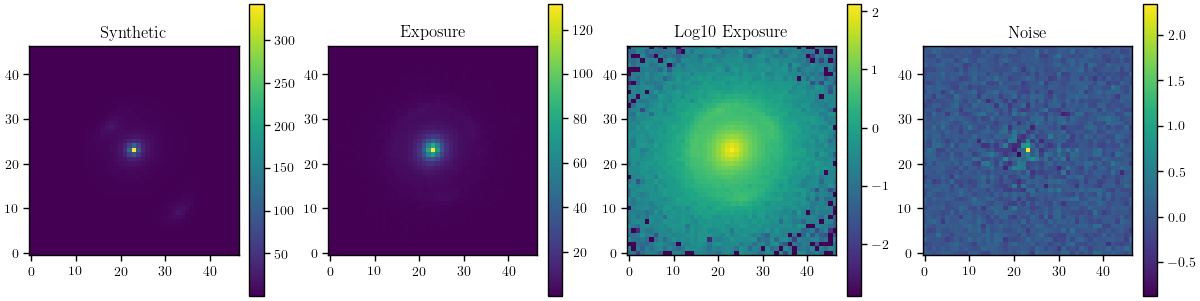

In [112]:
_, ax = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)
ax0 = ax[0].imshow(synth.image)
ax1 = ax[1].imshow(total_image)
ax2 = ax[2].imshow(np.log10(total_image))
ax3 = ax[3].imshow(noise)

plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.colorbar(ax2, ax=ax[2])
plt.colorbar(ax3, ax=ax[3])

ax[0].set_title('Synthetic')
ax[1].set_title('Exposure')
ax[2].set_title('Log10 Exposure')
ax[3].set_title('Noise')

plt.show()

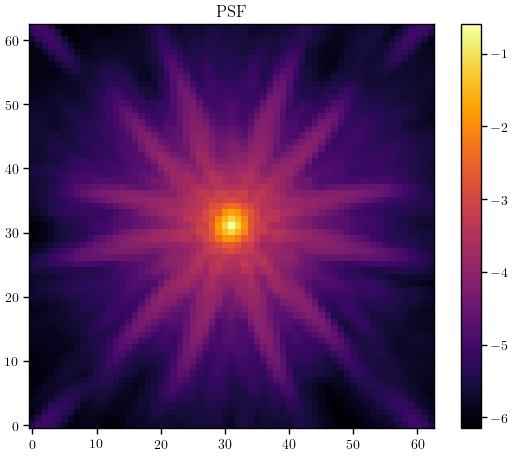

In [103]:
plt.imshow(np.log10(psf), cmap='inferno')
plt.colorbar()
plt.title('PSF')
plt.show()